# Artificial Bee Colony

In [1]:
using Plots

In [2]:
function rastrigin(x, A=10)
    return A * length(x) + sum(x.^2.0 - A * cos.(2π * x))
end;

In [3]:
function fitness_proportional_selection(fitness)
    min, max = extrema(fitness)
    absmin, absmax = abs(min), abs(max)
    
    if min < 0.0 && max <= 0.0
        fitness .+= -(max + min)
    elseif min < 0.0 && max >= 0.0
        fitness .+= (absmax >= absmin) ? 2absmin : (absmax + absmin)
    end

    cumulative_fitness = accumulate(+, fitness ./ sum(fitness))
    
    return [searchsortedfirst(cumulative_fitness, prob) for prob in rand(length(fitness))]
end;

In [4]:
function artificial_bee_colony(cost_function, n, dim, range, max_iterations, callback)
    #Initialize
    all_food_sources = Set(1:n)
    food_sources = rand(range, (dim, n))
    next_food_sources = copy(food_sources)
    fitness = map(cost_function, eachcol(food_sources))
    
    current_best_solution = argmax(fitness)
    best_solution = food_sources[:, current_best_solution]
    best_solution_fitness = fitness[current_best_solution]
    history = zeros(max_iterations)
   
    
    @gif for iter in 1:max_iterations
        # Employed bees
        # Generate candidates near each food source
        Φ = rand(-1.0:0.001:1.0, n)
        k = rand(1:dim, n)
        
        next_food_sources .= food_sources
        for ki in map(CartesianIndex, zip(k, 1:n))
            k, i = ki.I
            # Choose a random food source excluding the current to move towards/get away from depending on Φᵢ
            j = rand(1:n-1)
            if j >= i
                j += 1
            end
            next_food_sources[ki] += Φ[i] * (food_sources[ki] - food_sources[k, j])
        end
        # Calculate fitness (nectar)
        next_fitness = map(cost_function, eachcol(next_food_sources))
        # Greedy selection
        must_update = next_fitness .> fitness
        fitness[must_update] .= next_fitness[must_update]
        food_sources[:, must_update] .= next_food_sources[:, must_update]

        # Onlooker bees
        selected::Set{Integer} = Set(fitness_proportional_selection(fitness))
        
        # Scout bees
        abandoned = [x for x in setdiff(all_food_sources, selected)]
        k = rand(1:dim, length(abandoned))
        # Forget abandoned food sources and pick new sources from scouts
        for ki in map(CartesianIndex, zip(k, abandoned))
            food_sources[ki] = rand(range)
        end

        # Memorize best solution
        fitness = map(cost_function, eachcol(food_sources))
        current_best_solution = argmax(fitness)
        if fitness[current_best_solution] > best_solution_fitness
            best_solution = food_sources[:, current_best_solution]
            best_solution_fitness = fitness[current_best_solution]
        end
        history[iter] = best_solution_fitness
        callback(iter, best_solution_fitness, best_solution, history, food_sources, cost_function)
    end
    
    return best_solution_fitness, best_solution
end;

In [5]:
function on_iteration_callback(i, best_fitness, best_solution, history, solutions, cost_function)
    
    IJulia.clear_output(true)
    
    x, y = solutions[1, :], solutions[2, :]
    x_bounds, y_bounds = extrema(x), extrema(y)
    domain = min(x_bounds[1], y_bounds[1]):0.1:max(x_bounds[2], y_bounds[2])
    contour(domain, domain, (x, y) -> cost_function([x, y]))
    scatter!(solutions[1, :], solutions[2, :])
    scatter!([best_solution[1]], [best_solution[2]], label="Best")
    plot1 = title!("Iteration #$i")

    plot(1:i, history[1:i], label="Best fitness")
    plot2 = title!("Best fitness: $best_fitness")

    display(plot(plot1, plot2, layout=(1, 2), size=(1000,400)))
end;

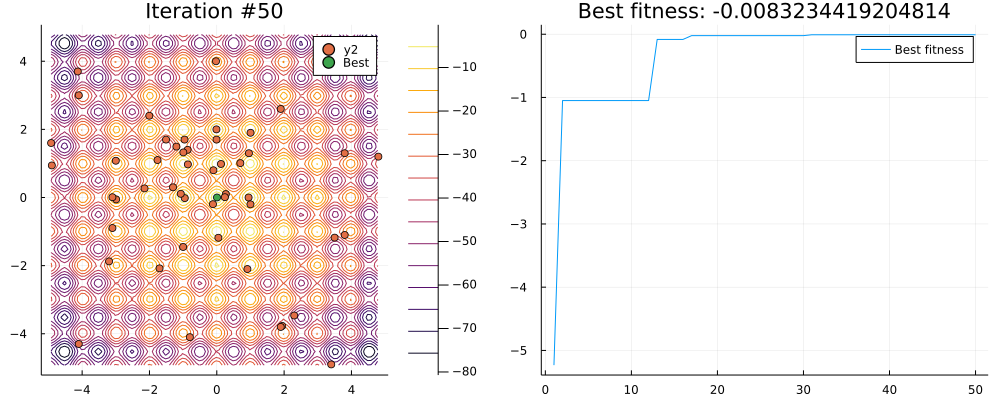

Fitness = 0.0083234419204814
Solution = [0.006400000000000003, 0.0009999999999998899]


┌ Info: Saved animation to 
│   fn = C:\Users\vnrju\Documents\Bioinspiradas\tmp.gif
└ @ Plots C:\Users\vnrju\.julia\packages\Plots\1RWWg\src\animation.jl:114


In [8]:
fitness, solution = artificial_bee_colony(x -> -rastrigin(x), 50, 2, -5.0:0.1:5.0, 50, on_iteration_callback)
println("Fitness = $(abs(fitness))\nSolution = $solution")